In [1]:
from scipy.optimize import leastsq
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.path as mpltPath


Defino funciones y parametros que voy a usar luego. Dist me calcula la distancia euclediana entre dos puntos. Func es el modelo lineal que paso como parametro al LeastSq. 

In [2]:
def dist(p1,p2):
    cant1 = np.abs(p1[0] - p2[0])
    cant2 = np.abs(p1[1] - p2[1])
    dist = np.sqrt((cant1**2) + (cant2**2))
    return dist

def func(params, x, y):
    a, b = params[0], params[1]
    residual = y-(a*x+b)
    return residual

def exp(params, x, y):
    a, b = params[0], params[1]
    residual = y-(a*x**b)
    return residual

def in_hex(poli):
    path = mpltPath.Path(poli)
    hex = False
    random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    while hex != True:
        if path.contains_points([random_point]) == True:
            hex = True
        else:
            random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    return random_point
    
    
params = [1, 1]

Defino los puntos del hexagono. Me genero un punto al azar que vive dentro del hexagono. Grafico

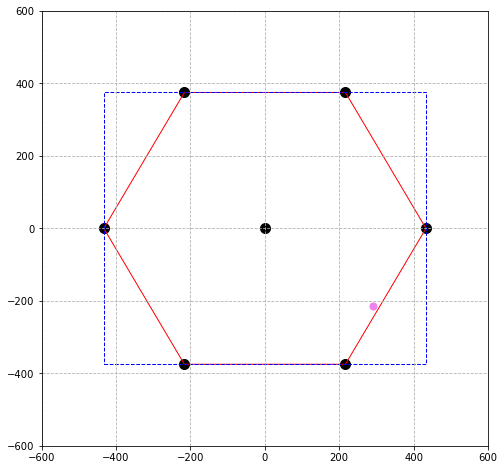

In [3]:
poligono = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0]]
rectangulo = [[-433,-375],[433,-433],[433,375],[-433,375]]
pointsx,pointsy = [-216.5,216.5,433,216.5,-216.5,-433.5] , [-375,-375,0,375,375,0]
random_point = in_hex(poligono)
centro = (0,0)


distancias = []
for i in range(len(poligono)):
    distancias.append(dist(random_point,poligono[i]))
    
distancias.append(dist(centro,random_point))
    

plt.figure(figsize=(8,8))
polygon = plt.Polygon(poligono,fill=None,edgecolor='r')
rectangle = plt.Rectangle(rectangulo[0],width = 865, height = 750,fill=None,linestyle = '--',edgecolor='b')
plt.gca().add_patch(polygon)
plt.gca().add_patch(rectangle)
plt.xlim(-600,600)
plt.ylim(-600,600)
plt.scatter(centro[0],centro[1],s = 100,c ='black')
plt.scatter(random_point[0],random_point[1],s = 50,c='violet')
plt.scatter(pointsx,pointsy,s = 100,c = 'black')
plt.grid(linestyle='--')
plt.show()




In [4]:
distancias

[530.3142231571089,
 175.23634651009627,
 259.1032610436211,
 595.065644087434,
 777.5786255535282,
 753.7806684788898,
 360.7920426339255]

Chequeo las distancias entre los verrtices para que sean todas aproximadamente 433. Chequeo que el centro este bien colocado tal que su distancia al resto de los vertices sea tambien 433.

In [5]:
for i in range(len(poligono)):
    if i == len(poligono)-1:
        print(f'disttancia entre vertices: {dist(poligono[0],poligono[len(poligono)-1])}')
    if i < len(poligono)-1:
        print(f'distancia entre vertices: {dist(poligono[i],poligono[i+1])}')
        
for i in range(len(poligono)):
    print(f'distancias entre vertices y el centro: {dist(centro,poligono[i])}')

distancia entre vertices: 433.0
distancia entre vertices: 433.00952645409546
distancia entre vertices: 433.00952645409546
distancia entre vertices: 433.0
distancia entre vertices: 433.00952645409546
disttancia entre vertices: 433.00952645409546
distancias entre vertices y el centro: 433.00952645409546
distancias entre vertices y el centro: 433.00952645409546
distancias entre vertices y el centro: 433.0
distancias entre vertices y el centro: 433.00952645409546
distancias entre vertices y el centro: 433.00952645409546
distancias entre vertices y el centro: 433.0


Genero los puntos y a partir de la relacion lineal.

Genero 1000 puntos de y al azar y obtengo los parametros de la recta que mejor los ajustan.

In [7]:
a1 = []
a2 = []

for i in range(1000):
    valores_y = (np.random.normal(loc = y, scale = sigma))
    a1.append(leastsq(func, params, (np.asarray(distancias), valores_y))[0][1])
    a2.append(leastsq(func, params, (np.asarray(distancias), valores_y))[0][0])
    
print(f'Parametros obtenidos por Monte carlo = {np.mean(a1),np.mean(a2)}')
print(f'Parametros originales = {(100,-100/433)}')                                                                                      


Parametros obtenidos por Monte carlo = (96.57975219355814, -0.22611871961645258)
Parametros originales = (100, -0.23094688221709006)


Grafico los histogramas de la pendiente y la ordenada

Text(0.5, 0, '$a_{2}$')

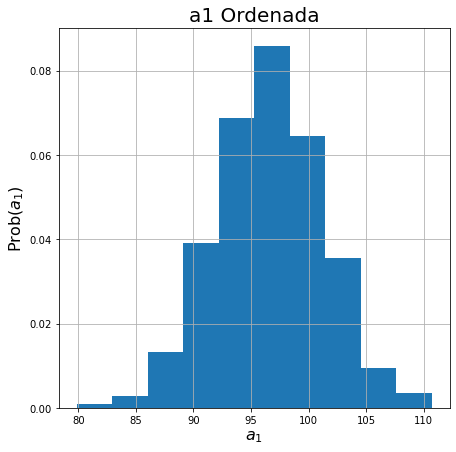

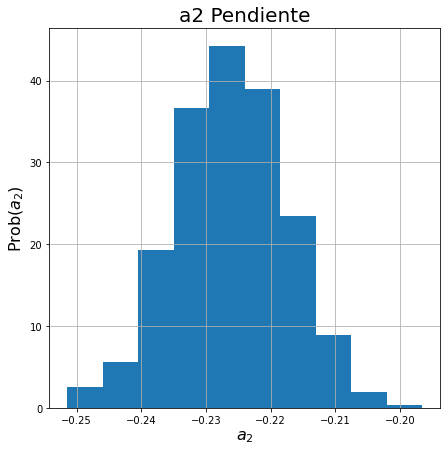

In [8]:
plt.figure(figsize=(7,7))
plt.hist(a1,density=True)
plt.title('a1 Ordenada',size = 20)
plt.grid()
plt.ylabel('Prob($a_{1}$)',size = 16)
plt.xlabel('$a_{1}$',size = 16)



plt.figure(figsize=(7,7))
plt.hist(a2,density=True)
plt.title('a2 Pendiente',size = 20)
plt.grid()
plt.ylabel('Prob($a_{2}$)',size = 16)
plt.xlabel('$a_{2}$',size = 16)

(array([-0.22952251, 97.84477424]), 3)


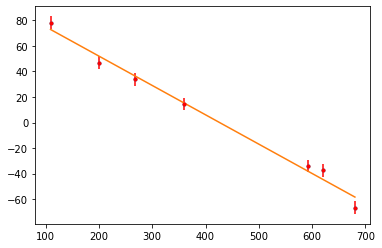

In [39]:
sigma = 5
ruido = np.random.normal(0, 5, 7)
y = 100 - (100/433)*np.asarray(distancias) 
signal = np.random.normal(y,sigma,7)
plt.plot(distancias,signal, '.')
plt.errorbar(distancias, signal, yerr=sigma, fmt=".", color="r")

a,b = leastsq(func, [1,1], (np.array(distancias), signal))[0]
cov = leastsq(func, [1,1], (np.array(distancias), signal))
z = np.linspace(min(distancias),max(distancias),1000)              
plt.plot(z, b+a*z)
print(leastsq(func, [1,1], (np.array(distancias), signal)))

In [29]:
x = np.array(distancias)
x2 = signal
Sum_x = np.sum(x)
Sum_x2 = np.sum(x**2)
N = len(x)
Delta = (N * Sum_x2) - (Sum_x ** 2)

cov = np.empty(shape=[2, 2])
cov[0,0] = (sigma**2/Delta)*Sum_x2
cov[1,1] = (sigma**2/Delta)*N
cov[1,0] = -(sigma**2/Delta)*Sum_x
cov[0,1] = -(sigma**2/Delta)*Sum_x

cov

array([[ 1.68198804e+01, -3.27709891e-02],
       [-3.27709891e-02,  8.10613756e-05]])

In [11]:
var_y = cov[0,0] + z**2*cov[1,1] +2*z*cov[0,1] 
sigma_y = np.sqrt(var_y)


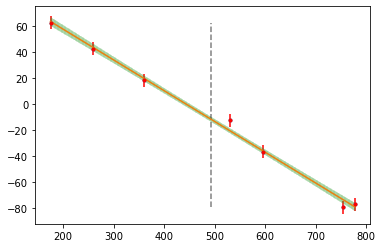

In [12]:
plt.plot(distancias,signal, '.')
plt.errorbar(distancias, signal, yerr=sigma, fmt=".", color="r")
plt.plot(z,b+a*z)
plt.errorbar(z,b+a*z, yerr=np.sqrt(var_y),alpha=0.1, 
             fmt='',label='Banda de error' )

xmin = - cov[0][1]/cov[1][1]
plt.vlines(xmin, min(signal), max(signal), alpha=0.5, linestyles='dashed',color='black')

In [13]:
aux = []
for j in range(30000):
    distancias = []
    random_point = in_hex(poligono)
    for i in range(len(poligono)):
        
        distancias.append(dist(random_point,poligono[i]))
    
    distancias.append(dist(centro,random_point))
    aux.append(np.mean(distancias))

Text(0, 0.5, 'Probabilidad')

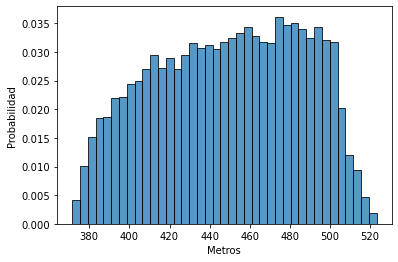

In [14]:
import seaborn as sns

sns.histplot(data=aux, stat='probability');
plt.xlabel('Metros')
plt.ylabel("Probabilidad")

In [15]:
distancias = []
for i in range(len(poligono)):
    random_point = in_hex(poligono)
    distancias.append(dist(random_point,poligono[i]))
    
distancias.append(dist(centro,random_point))


In [16]:
np.mean(distancias)

404.2737846879988

<ErrorbarContainer object of 3 artists>

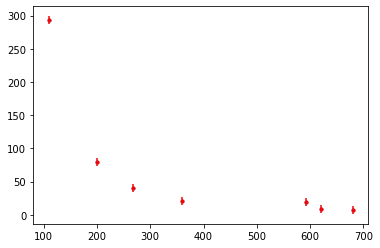

In [17]:
"""
Aplico power law

"""

from scipy.optimize import curve_fit

def powerlaw(r, s0, b):  # r0 no es variable aleatoria
    r0 = 300
    return s0*(r/r0)**(-b)


r0 = 300 #metros 
s0 = 35 #VEM
b = 2.1
r = np.asarray(distancias)
sigma = np.sqrt(s0)



y = powerlaw(r,s0,b)

signal = np.random.normal(y,sigma,7)


plt.plot(distancias,signal, '.')
plt.errorbar(distancias, signal, yerr=sigma, fmt=".", color="r")

In [18]:
parametros_iniciales=[35, 2.1]


popt, pcov = curve_fit(powerlaw, distancias, signal, p0=parametros_iniciales)


In [19]:
pcov

array([[ 6.55634276e+00, -1.96171909e-01],
       [-1.96171909e-01,  6.18911705e-03]])

In [20]:
s0_est = popt[0]
b_est = popt[1]

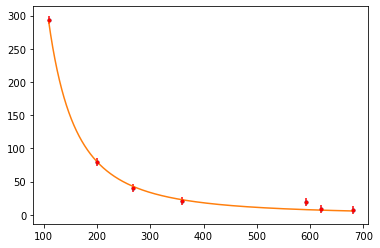

In [21]:
plt.plot(distancias,signal, '.')
plt.errorbar(distancias, signal, yerr=sigma, fmt=".", color="r")


x = np.linspace(min(r),max(r),10000)
plt.plot(x, powerlaw(x,s0_est,b_est),'-')

In [22]:
sigma_s0 = np.sqrt(pcov[0,0])
sigma_b = np.sqrt(pcov[1,1])
cov_b_s0 = pcov[0,1]

var_y = (x/r0)**(-2*b_est) * ( (s0_est*np.log(x/r0)*sigma_b)**2 + sigma_s0**2 - 2*s0_est * np.log(x/r0)*cov_b_s0 )

#var_y = (x/r0)**(-2*b_est)*sigma_s0**2 + (s0_est*(x/r0)**(-b_est)*np.log(x/r0)*sigma_b)**2 + 2*(x/r0)**(-b_est)*(-s0_est*(x/r0)**(-b_est))*np.log(x/r0)*cov_b_s0

In [23]:
sigma_b

0.07867094157362911

<ErrorbarContainer object of 3 artists>

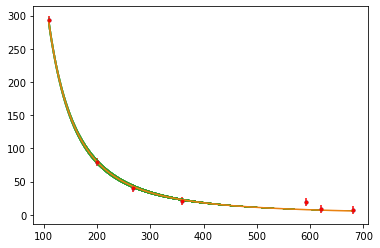

In [24]:
plt.plot(distancias,signal, '.')
plt.errorbar(distancias, signal, yerr=sigma, fmt=".", color="r")


x = np.linspace(min(r),max(r),10000)
plt.plot(x, powerlaw(x,s0_est,b_est),'-')

plt.errorbar(x,powerlaw(x,s0_est,b_est), yerr = np.sqrt(var_y), alpha=0.1)

In [25]:
np.where(var_y == min(var_y))

(array([9999]),)

In [26]:
var_y

array([28.12512999, 28.02477054, 27.92506061, ...,  0.66183465,
        0.66165882,  0.66148305])